# Instruction

In [ ]:
# 1- read content and report
# 2- use tensorflow
# 3- preprocess: normalize
# 4- train: 70- test: 30

# 5- cnn model --> a) better activation function   b) why using padding?    c) how to defeat overfitting
# 6- use augmentation for trainting and retrain

# 7- reprot f1 score and accuracy for each model

# Import Packages

In [ ]:
import numpy as np
import os
from sklearn.metrics import f1_score
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle           
import matplotlib.pyplot as plt             
import cv2                                 
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm

In [ ]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names)
IMAGE_SIZE = (150, 150)

# Loading the Data

In [ ]:
def load_data():
    datasets = ['./archive/seg_train', './archive/seg_test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [ ]:
(train_images, train_labels), (test_images, test_labels) = load_data()

In [ ]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=25)

# 

## Scale the data

In [7]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

# 

# Explore the dataset


In [8]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print ("Number of training examples: {}".format(n_train))
print ("Number of testing examples: {}".format(n_test))
print ("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 14034
Number of testing examples: 3000
Each image is of size: (150, 150)


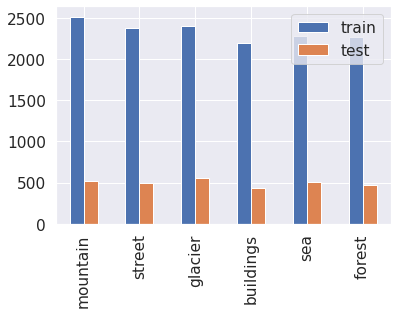

In [9]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_, test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=class_names
            ).plot.bar()
plt.show()

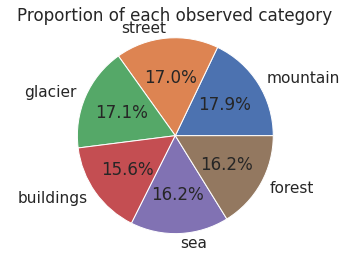

In [10]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

# 

## Visualize the data


In [11]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label from the labels array.
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{} : '.format(index) + class_names[labels[index]])
    plt.show()

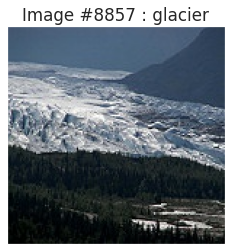

In [12]:
display_random_image(class_names, train_images, train_labels)

In [13]:
def display_examples(class_names, images, labels):
    """
        Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()

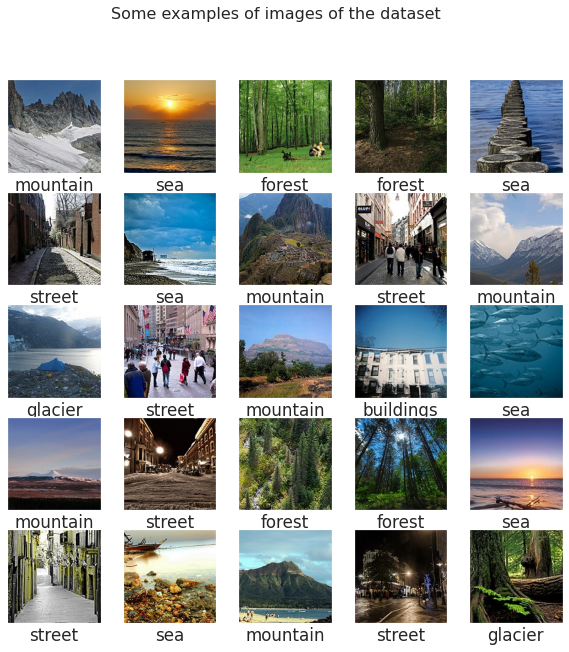

In [14]:
display_examples(class_names, train_images, train_labels)

# 

# Model Creation

In [15]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3), padding='same'), 
    tf.keras.layers.AveragePooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', padding= "same"),
    tf.keras.layers.AveragePooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

2022-01-27 14:01:48.176252: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/roshan/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-01-27 14:01:48.176278: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-27 14:01:48.176312: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (roshan): /proc/driver/nvidia/version does not exist
2022-01-27 14:01:48.176510: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 average_pooling2d (AverageP  (None, 75, 75, 32)       0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        9248      
                                                                 
 average_pooling2d_1 (Averag  (None, 37, 37, 32)       0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 43808)             0         
                                                                 
 dense (Dense)               (None, 128)               5

In [18]:
early_stopping = EarlyStopping(monitor='val_loss')
history = model.fit(train_images, train_labels, batch_size=64, epochs=10, validation_split = 0.3,  callbacks=[early_stopping])

2022-01-27 14:02:05.816240: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2652210000 exceeds 10% of free system memory.


Epoch 1/10
154/154 [==============================] - ETA: 0s - loss: 1.0717 - accuracy: 0.5890

2022-01-27 14:03:44.631847: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1136970000 exceeds 10% of free system memory.


154/154 [==============================] - 112s 727ms/step - loss: 1.0717 - accuracy: 0.5890 - val_loss: 0.9897 - val_accuracy: 0.6191
Epoch 2/10
154/154 [==============================] - 113s 731ms/step - loss: 0.7380 - accuracy: 0.7242 - val_loss: 0.7525 - val_accuracy: 0.7231


In [19]:
model.save('./section5.h5')

In [ ]:
savedModel=load_model('./section5.h5')
savedModel.summary()

In [20]:
model.evaluate(test_images, test_labels)

2022-01-27 14:05:53.692475: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 810000000 exceeds 10% of free system memory.


94/94 [==============================] - 9s 85ms/step - loss: 0.7638 - accuracy: 0.7153


[0.7638465762138367, 0.7153333425521851]

In [21]:
pred_label = np.argmax(model.predict(test_images), axis=1)

2022-01-27 14:06:04.659929: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 810000000 exceeds 10% of free system memory.


In [22]:
f1_score(y_true=test_labels, y_pred=pred_label, average='macro')

0.7091437556295643

# 

# Data Augmentation

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Add data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,horizontal_flip=True,shear_range=0.2,  
    zoom_range=0.2, validation_split=0.1)


train_generator=train_datagen.flow_from_directory(
      './archive/seg_train/',
      target_size=(150,150),
      batch_size=64,
      class_mode='sparse',
      seed=2209,
      subset='training')

test_datagen = ImageDataGenerator(rescale = 1./255.)
test_generator = test_datagen.flow_from_directory(
    './archive/seg_test/', 
    target_size=(150,150),
    batch_size=32,
    class_mode='sparse',
    seed=2209
) 


Found 12632 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3), padding='same'), 
    tf.keras.layers.AveragePooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', padding= "same"),
    tf.keras.layers.AveragePooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
])

In [25]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 150, 150, 32)      896       
                                                                 
 average_pooling2d_2 (Averag  (None, 75, 75, 32)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 75, 32)        9248      
                                                                 
 average_pooling2d_3 (Averag  (None, 37, 37, 32)       0         
 ePooling2D)                                                     
                                                                 
 flatten_1 (Flatten)         (None, 43808)             0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [27]:
history = model.fit(train_generator, batch_size=64, epochs=10)

Epoch 1/10
198/198 [==============================] - 139s 695ms/step - loss: 1.1410 - accuracy: 0.5672
Epoch 2/10
198/198 [==============================] - 138s 697ms/step - loss: 0.8654 - accuracy: 0.6799
Epoch 3/10
198/198 [==============================] - 138s 696ms/step - loss: 0.7788 - accuracy: 0.7183
Epoch 4/10
198/198 [==============================] - 137s 692ms/step - loss: 0.6933 - accuracy: 0.7495
Epoch 5/10
198/198 [==============================] - 137s 689ms/step - loss: 0.6465 - accuracy: 0.7665
Epoch 6/10
198/198 [==============================] - 136s 688ms/step - loss: 0.5820 - accuracy: 0.7885
Epoch 7/10
198/198 [==============================] - 136s 686ms/step - loss: 0.5329 - accuracy: 0.8088
Epoch 8/10
198/198 [==============================] - 137s 692ms/step - loss: 0.4991 - accuracy: 0.8238
Epoch 9/10
198/198 [==============================] - 136s 687ms/step - loss: 0.4667 - accuracy: 0.8308
Epoch 10/10
198/198 [==============================] - 137s 690m

In [28]:
model.save('./section6.h5')

In [ ]:
savedModel=load_model('./section6.h5')
savedModel.summary()

In [29]:
model.evaluate(test_generator)

94/94 [==============================] - 9s 98ms/step - loss: 0.5590 - accuracy: 0.8057


[0.5590043067932129, 0.8056666851043701]

In [30]:
pred_labels = np.argmax(model.predict(test_images), axis=1)

2022-01-27 14:29:54.383200: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 810000000 exceeds 10% of free system memory.


In [31]:
f1_score(y_true=test_labels, y_pred=pred_label, average='macro')

0.7091437556295643